In [1]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

C:\Users\Ron.Cao.ELOTOUCH\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train_1.csv")

In [3]:
#only take the first 50 times
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')

In [4]:
train_flattened.date.unique()

array(['2016-11-12', '2016-11-13', '2016-11-14', '2016-11-15',
       '2016-11-16', '2016-11-17', '2016-11-18', '2016-11-19',
       '2016-11-20', '2016-11-21', '2016-11-22', '2016-11-23',
       '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27',
       '2016-11-28', '2016-11-29', '2016-11-30', '2016-12-01',
       '2016-12-02', '2016-12-03', '2016-12-04', '2016-12-05',
       '2016-12-06', '2016-12-07', '2016-12-08', '2016-12-09',
       '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13',
       '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-17',
       '2016-12-18', '2016-12-19', '2016-12-20', '2016-12-21',
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
       '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
       '2016-12-30', '2016-12-31'], dtype=object)

In [5]:
len(train)

145063

In [6]:
#how pandas melt function works
df = pd.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
         'B': {0: 1, 1: 3, 2: 5},
                 'C': {0: 2, 1: 4, 2: 6}})

In [7]:
df

,A,B,C
0,a,1,2
1,b,3,4
2,c,5,6


In [8]:
pd.melt(df, id_vars=['A'], value_vars=['B','C'])

,A,variable,value
0,a,B,1
1,b,B,3
2,c,B,5
3,a,C,2
4,b,C,4
5,c,C,6


In [9]:
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')

In [10]:
train_flattened['date'].values

array(['2016-11-12T00:00:00.000000000', '2016-11-12T00:00:00.000000000',
       '2016-11-12T00:00:00.000000000', ...,
       '2016-12-31T00:00:00.000000000', '2016-12-31T00:00:00.000000000',
       '2016-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [11]:
train_flattened.date.dt.dayofweek.unique()

array([5, 6, 0, 1, 2, 3, 4], dtype=int64)

In [12]:
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [13]:
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())

In [14]:
train_flattened.groupby(['Page'])['Visits'].median()

Page
!vote_en.wikipedia.org_all-access_all-agents                                                           2.0
!vote_en.wikipedia.org_all-access_spider                                                               1.0
!vote_en.wikipedia.org_desktop_all-agents                                                              2.0
"Awaken,_My_Love!"_en.wikipedia.org_all-access_all-agents                                           6213.0
"Awaken,_My_Love!"_en.wikipedia.org_all-access_spider                                                 61.0
"Awaken,_My_Love!"_en.wikipedia.org_desktop_all-agents                                              3726.5
"European_Society_for_Clinical_Investigation"_en.wikipedia.org_all-access_all-agents                   1.0
"European_Society_for_Clinical_Investigation"_en.wikipedia.org_all-access_spider                       1.0
"European_Society_for_Clinical_Investigation"_en.wikipedia.org_desktop_all-agents                      1.0
"Heroes"_(David_Bowie_album)_en.

In [15]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

In [16]:
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

In [17]:
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [18]:
train_flattened.head()

,date,Visits,weekend,mean,median
Page,,,,,
!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0


In [19]:
train_flattened.reset_index(drop=False,inplace=True)


In [20]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())


In [21]:
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

In [22]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


## Aggregation & Visualization

In [23]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()

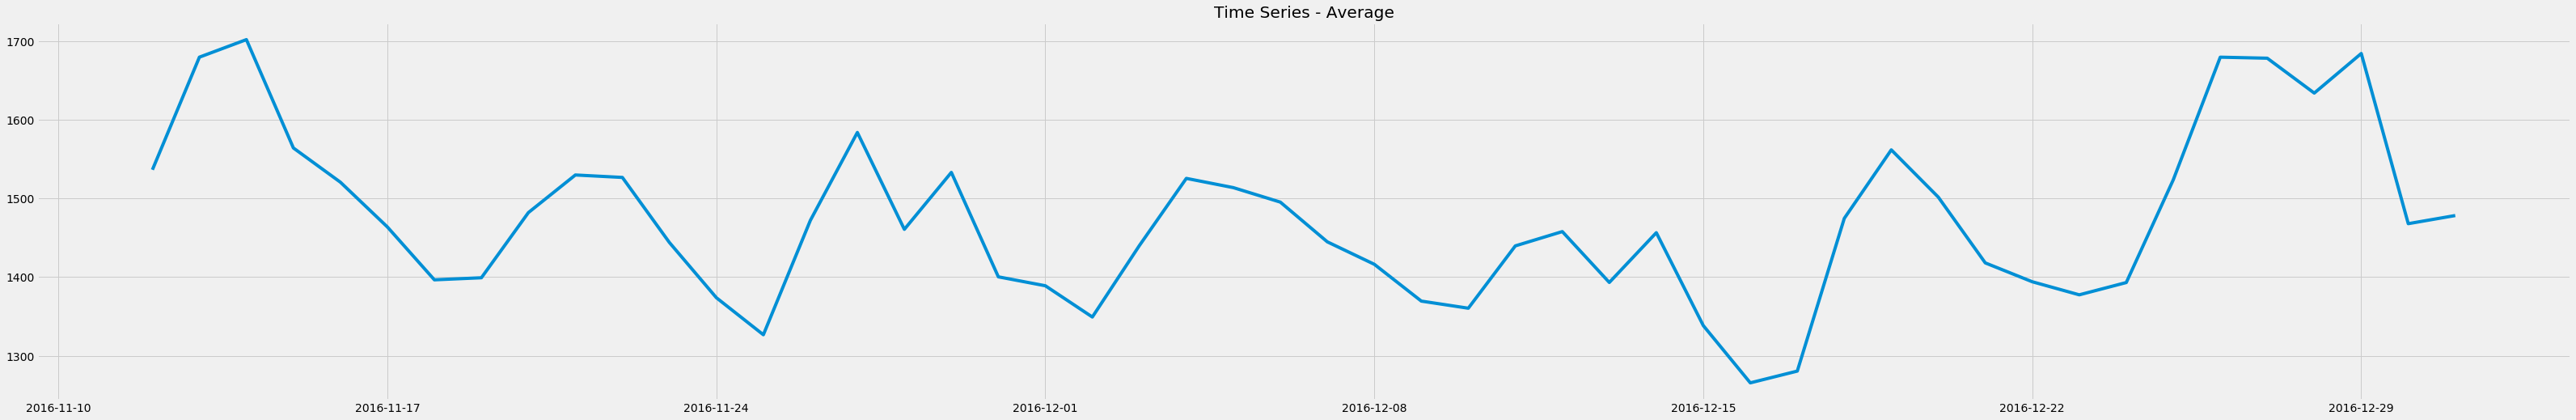

In [24]:
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

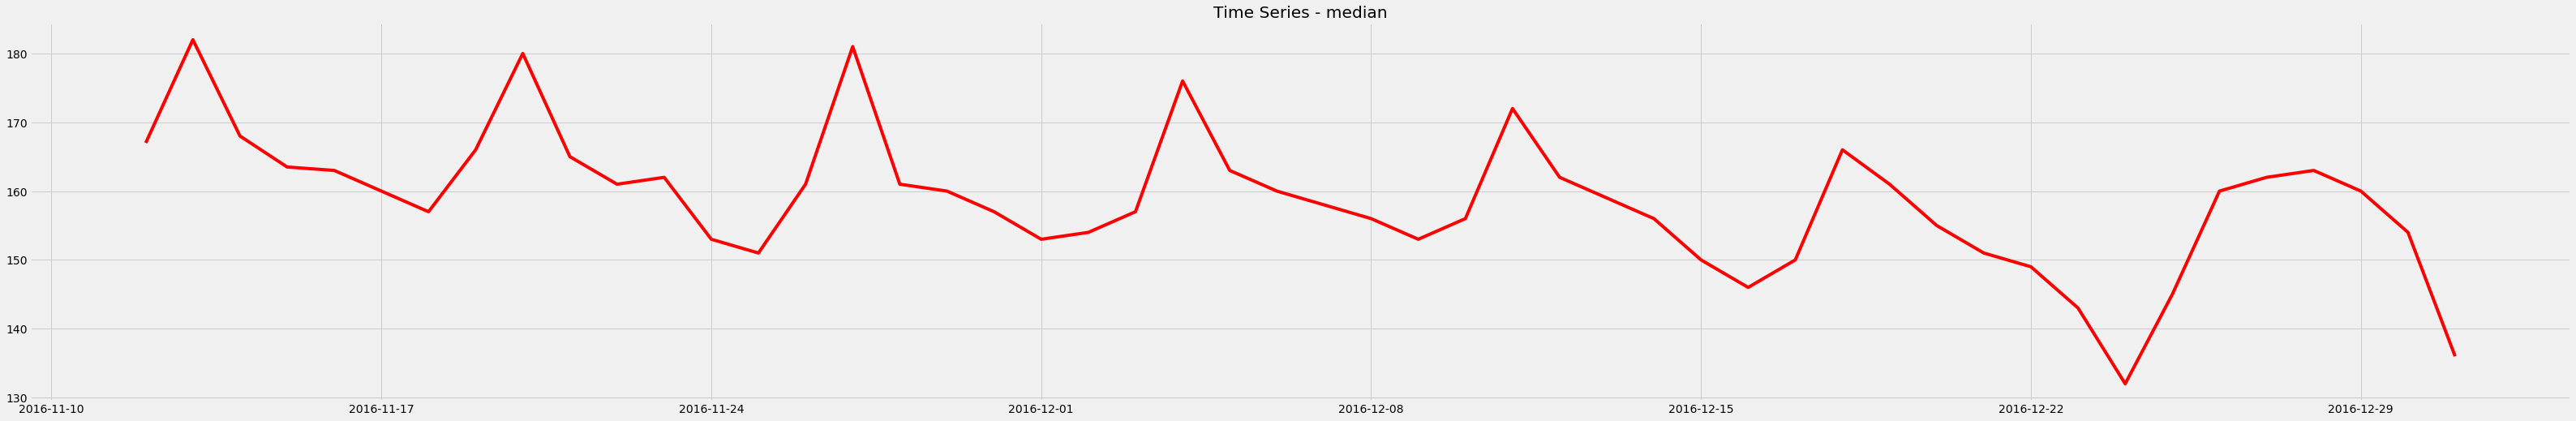

In [25]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

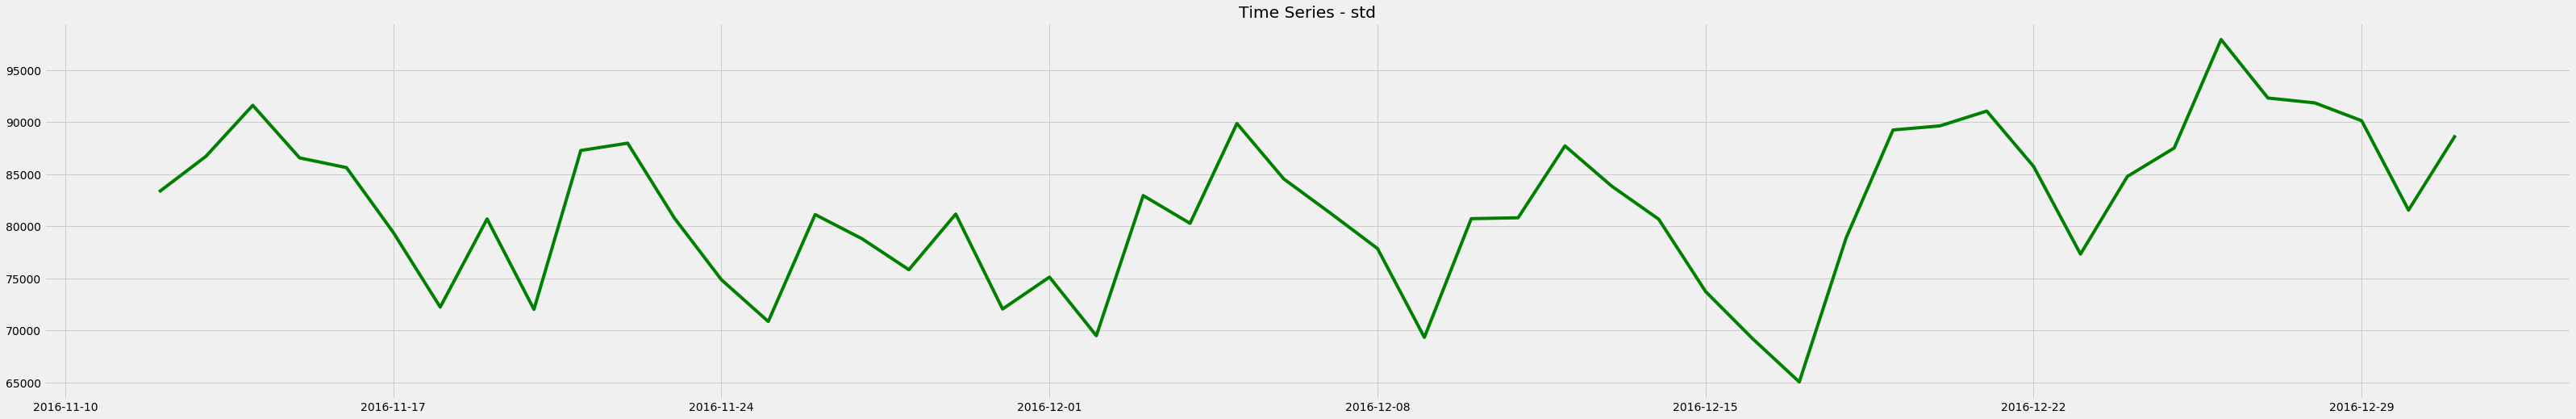

In [26]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [27]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


In [28]:
# For the next graphics
train_flattened['month']=train_flattened['month'].map(lambda x:str(x))
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [29]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day,month_num,weekday_num
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,06 - Saturday,2016,11 - November,12,11,5
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,07 - Sunday,2016,11 - November,13,11,6
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,01 - Monday,2016,11 - November,14,11,0
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,02 - Tuesday,2016,11 - November,15,11,1
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,03 - Wednesday,2016,11 - November,16,11,2


In [30]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()

In [31]:
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)

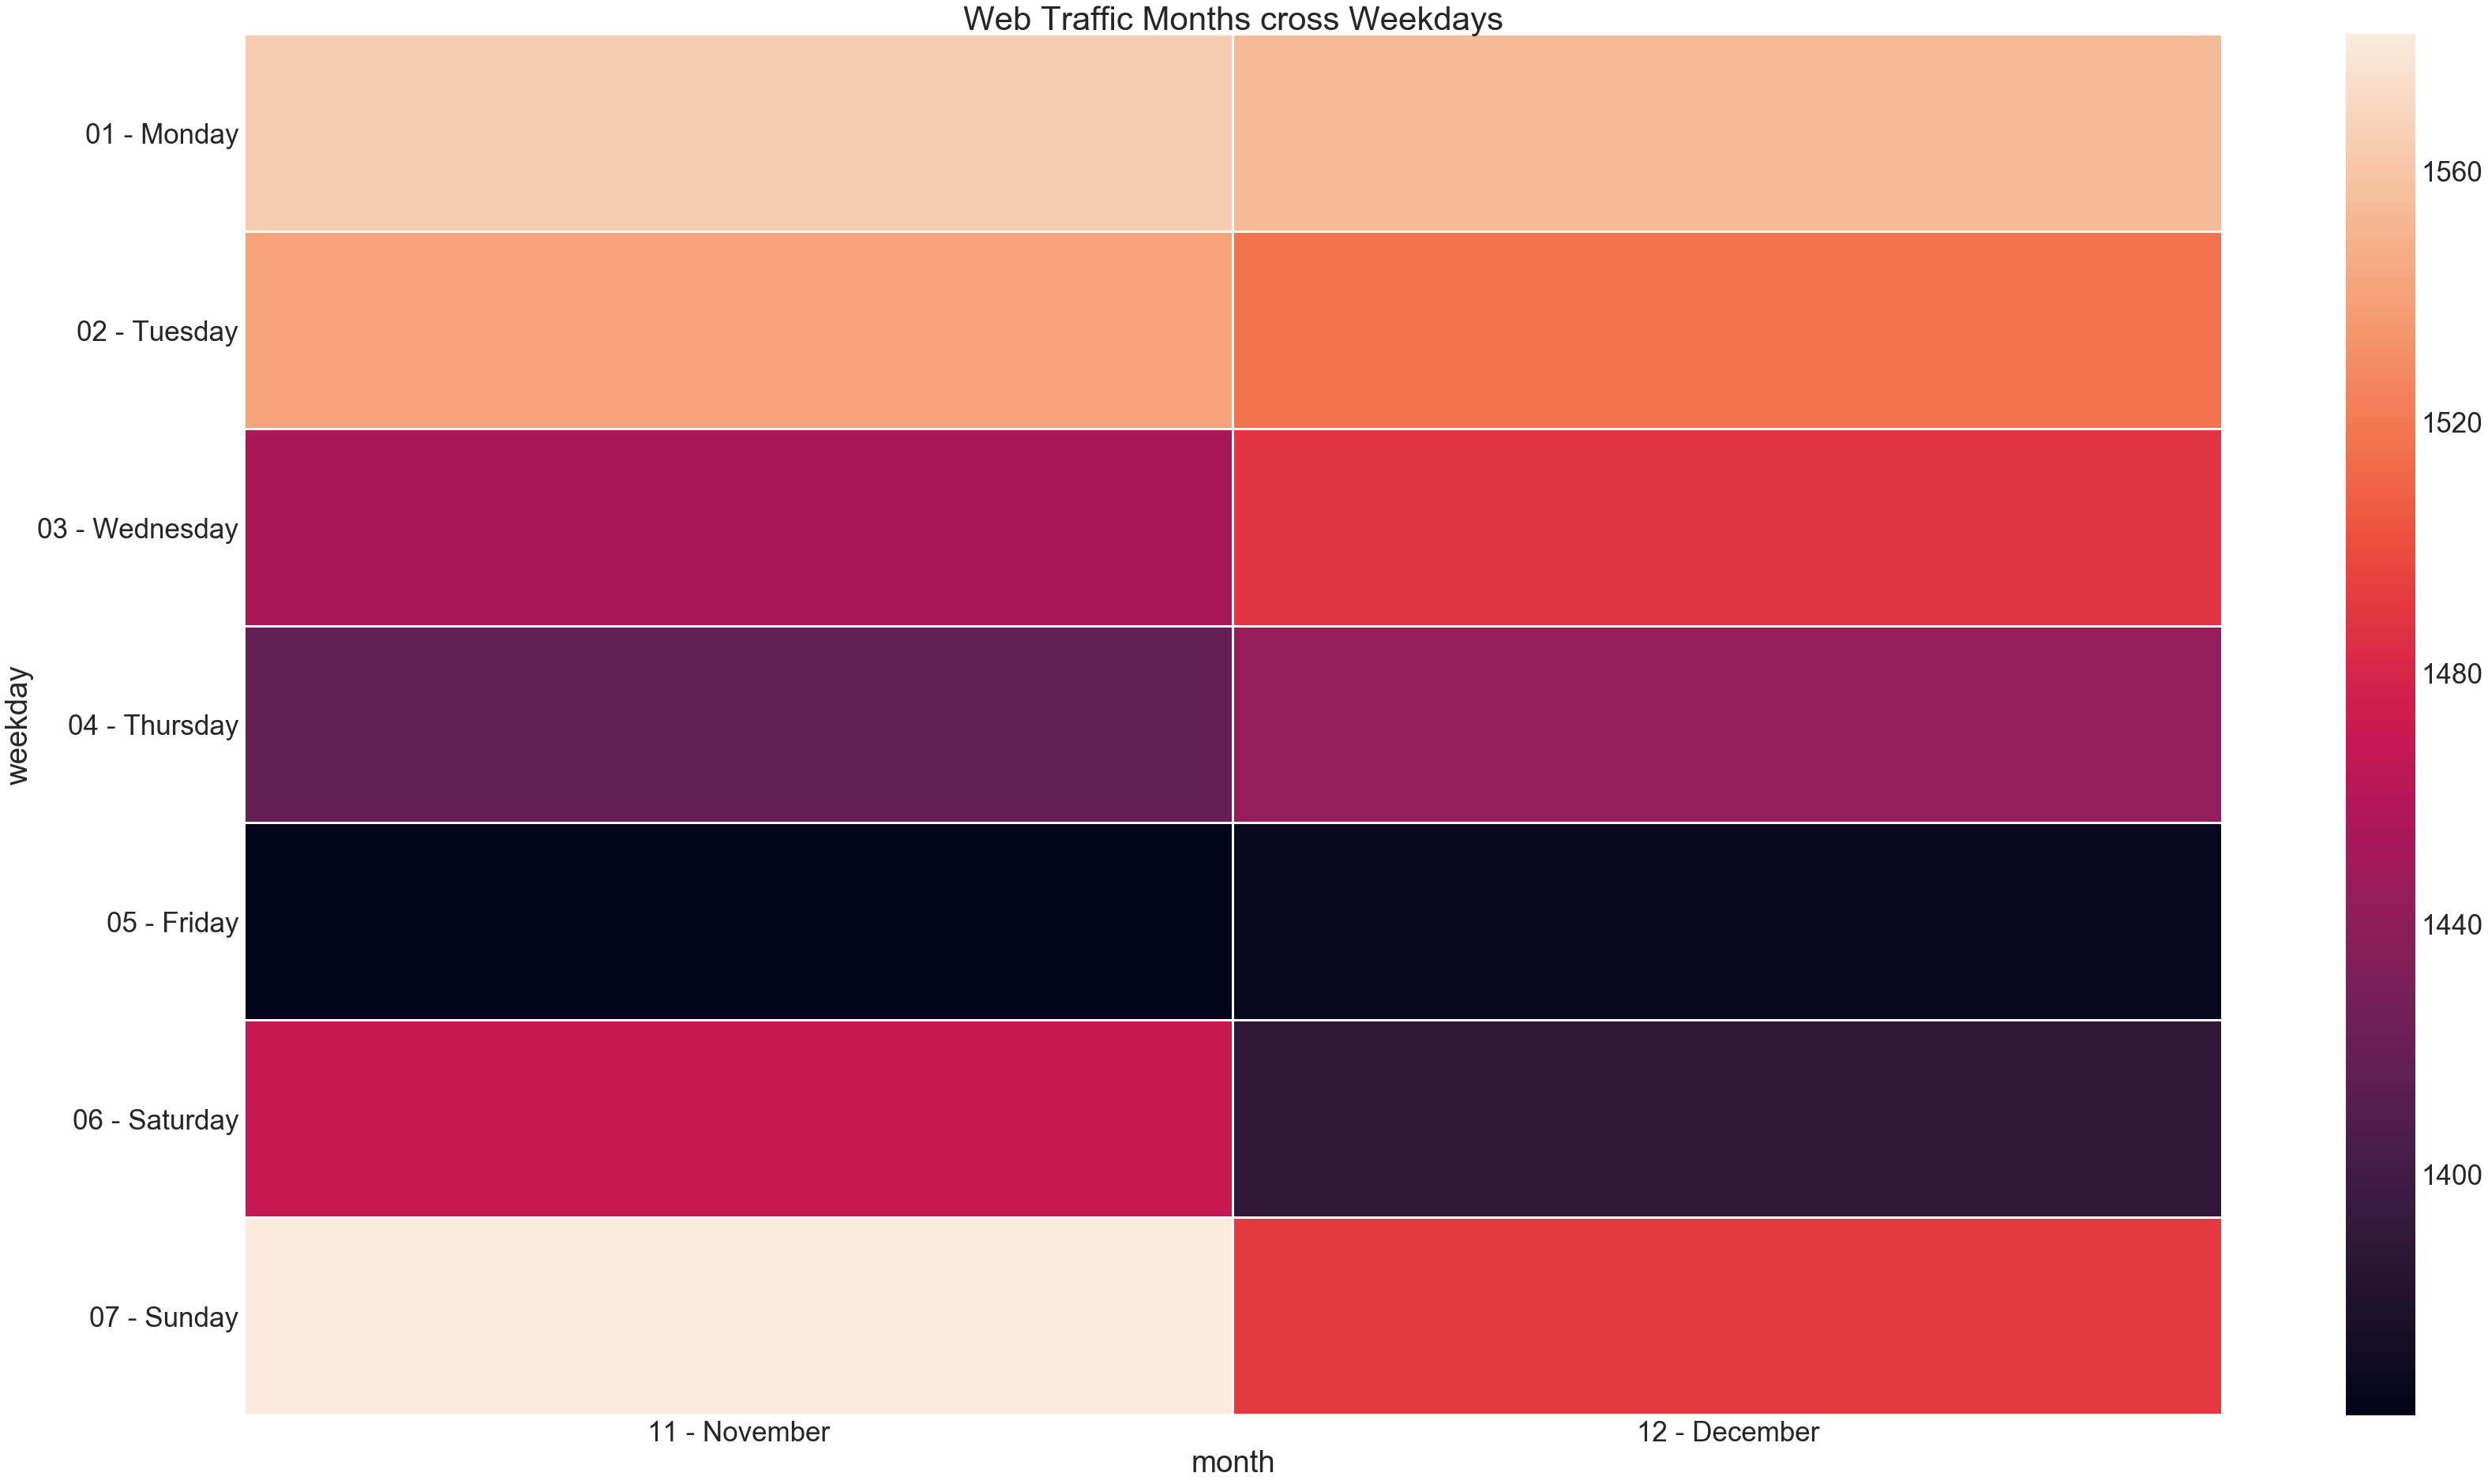

In [32]:
sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

In [33]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

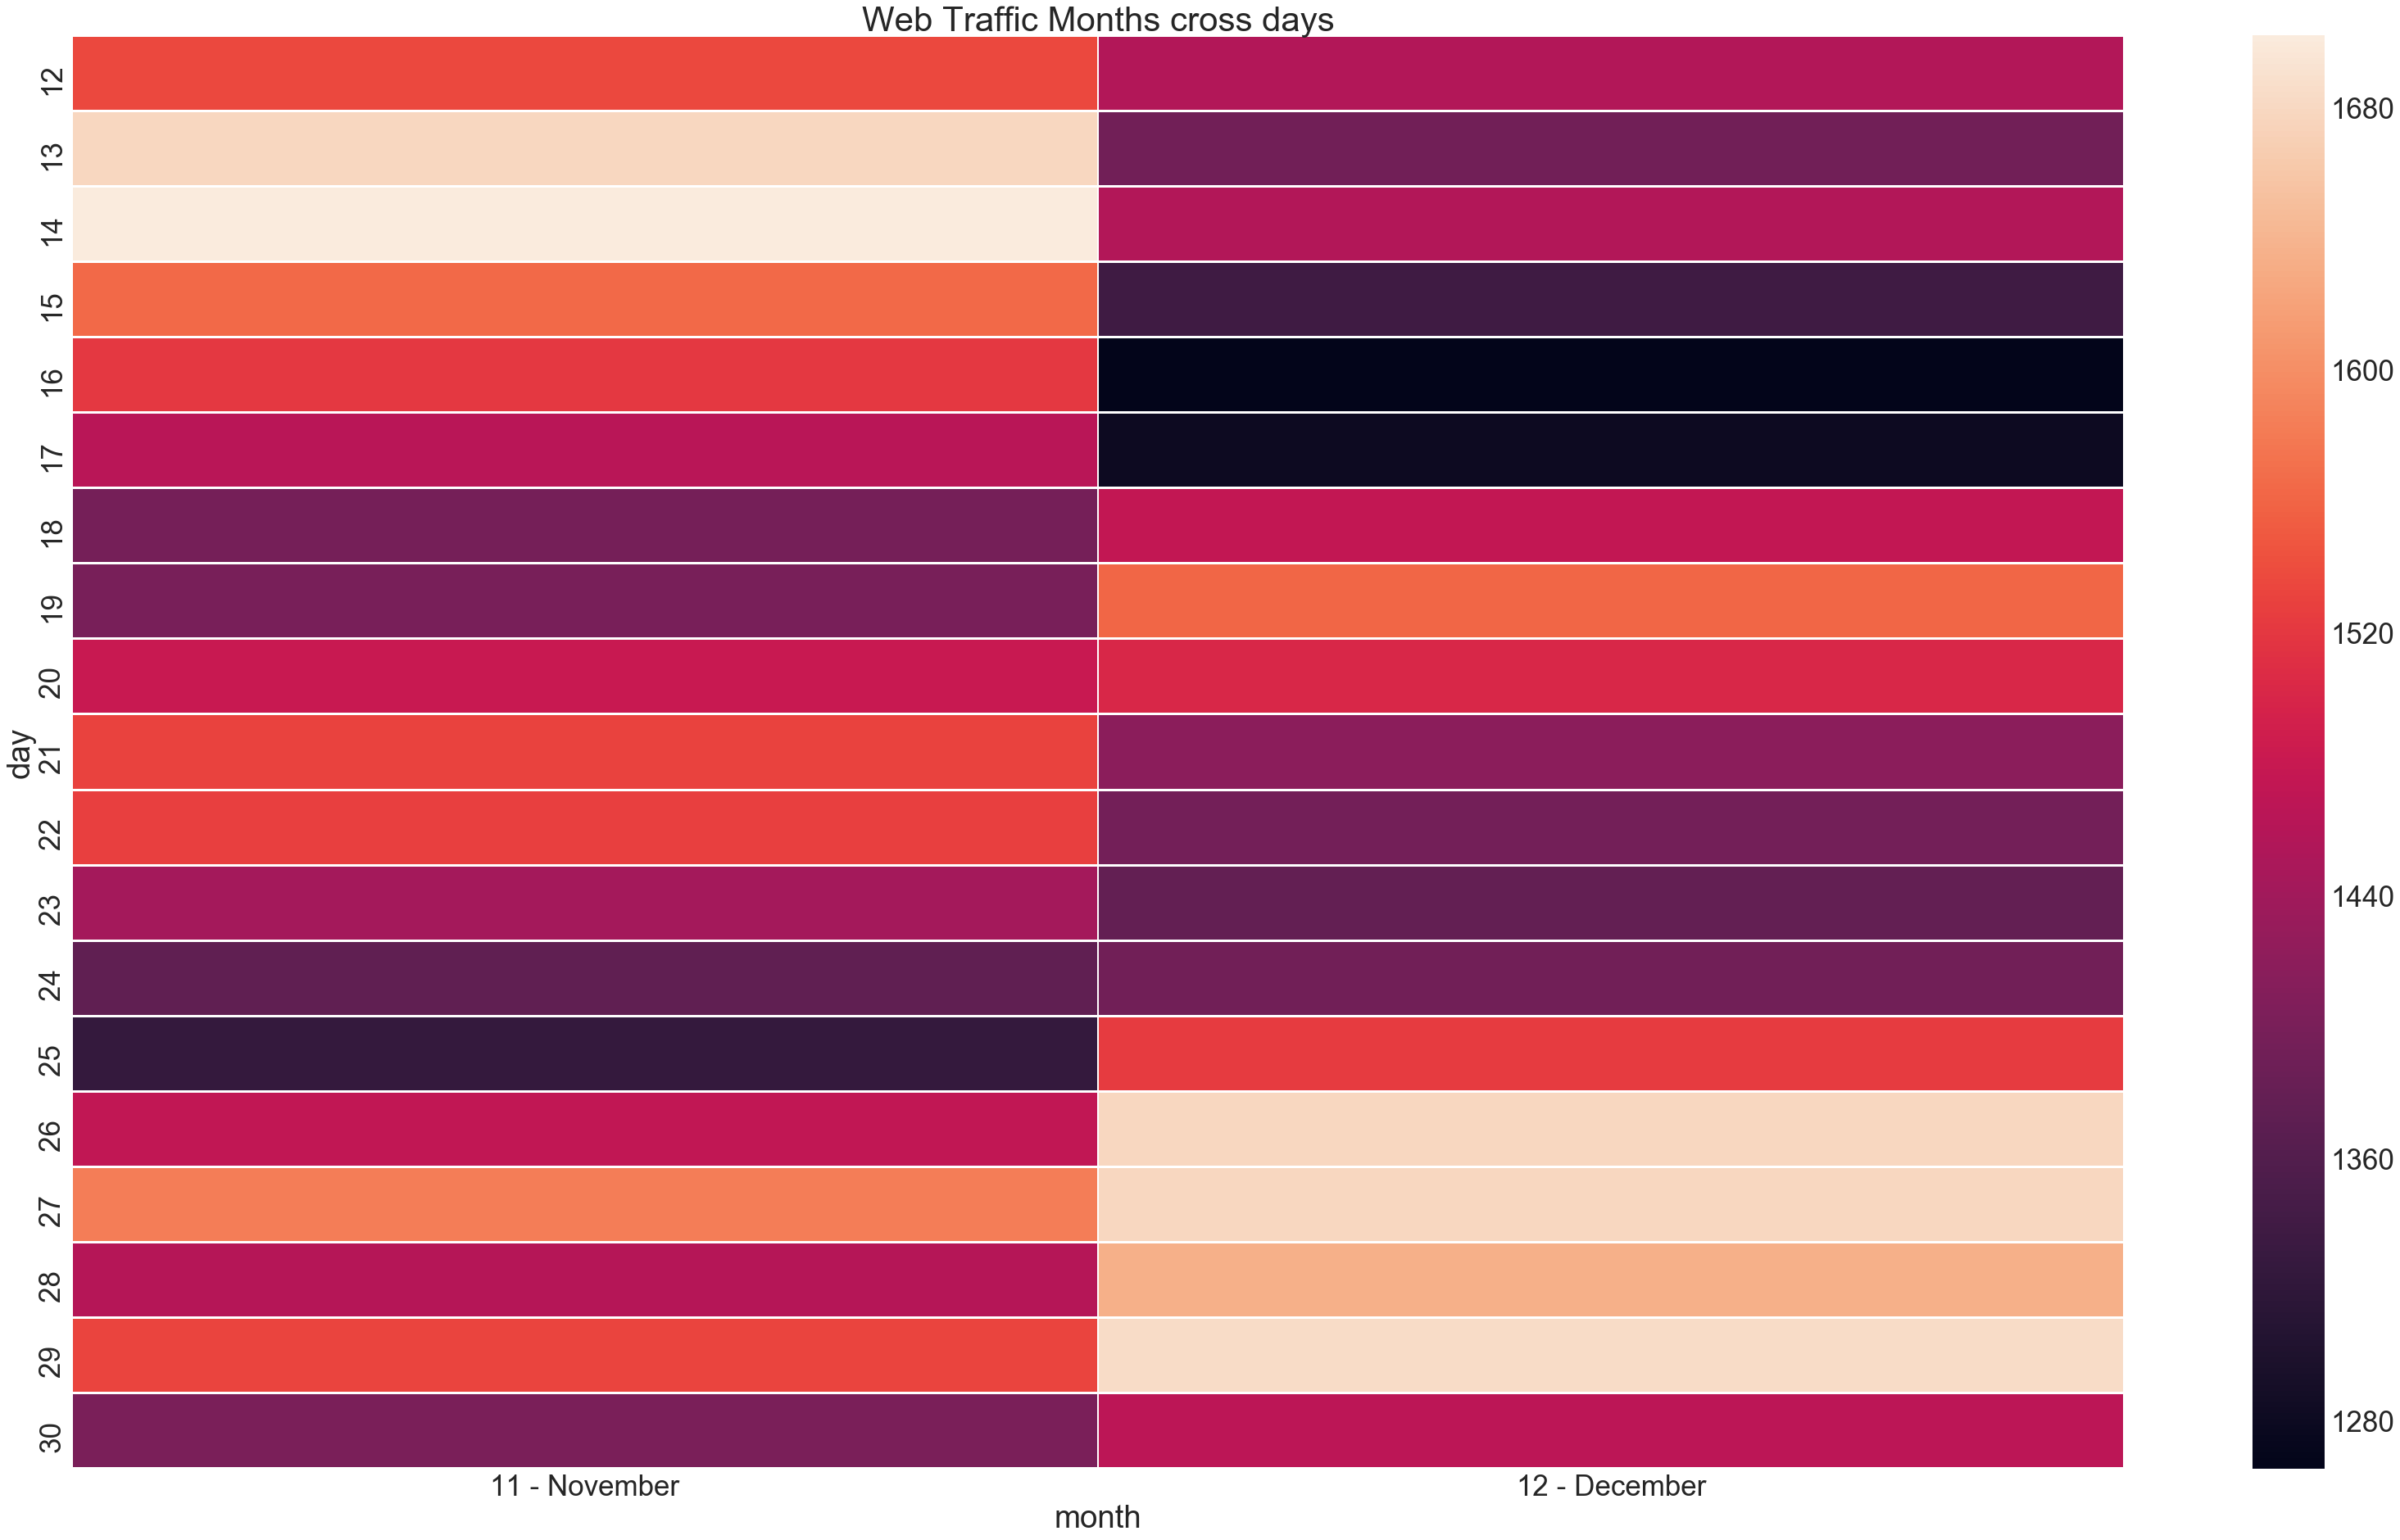

In [34]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

## Regression

In [35]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means.head()

,date,Visits
0,2016-11-12,1536.471757
1,2016-11-13,1679.630589
2,2016-11-14,1701.941831
3,2016-11-15,1564.172228
4,2016-11-16,1520.673959


In [36]:
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])

In [37]:
times_series_means.head()

,date,Visits,weekday,Date_str,year,month,day
0,2016-11-12,1536.471757,5,2016-11-12 00:00:00,2016,11,12 00:00:00
1,2016-11-13,1679.630589,6,2016-11-13 00:00:00,2016,11,13 00:00:00
2,2016-11-14,1701.941831,0,2016-11-14 00:00:00,2016,11,14 00:00:00
3,2016-11-15,1564.172228,1,2016-11-15 00:00:00,2016,11,15 00:00:00
4,2016-11-16,1520.673959,2,2016-11-16 00:00:00,2016,11,16 00:00:00


In [38]:
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()

,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16


In [39]:
times_series_means.reset_index(drop=True,inplace=True)

In [40]:
times_series_means

,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16
5,2016-11-17,1463.751937,3,2016,11,17
6,2016-11-18,1396.544145,4,2016,11,18
7,2016-11-19,1399.170412,5,2016,11,19
8,2016-11-20,1482.018739,6,2016,11,20
9,2016-11-21,1529.844585,0,2016,11,21


In [41]:
times_series_means.iloc[1:, 1].values#.as_matrix() #- times_series_means.iloc[:len(times_series_means)-1, 1].as_matrix()

array([ 1679.63058931,  1701.94183062,  1564.17222839,  1520.67395867,
        1463.75193666,  1396.54414535,  1399.1704118 ,  1482.0187392 ,
        1529.84458489,  1526.72394436,  1444.04389824,  1373.81463827,
        1326.70910719,  1472.10722375,  1583.90313338,  1460.71908225,
        1533.142157  ,  1400.35571666,  1389.00719134,  1349.26677319,
        1440.03653068,  1525.51159668,  1513.75852789,  1495.34191969,
        1444.83066422,  1416.28916166,  1369.50114278,  1360.45121537,
        1439.70342517,  1457.87765412,  1393.21735652,  1456.49566174,
        1338.35625066,  1265.57184958,  1280.52359651,  1474.68220684,
        1561.78993148,  1501.70135759,  1418.0630698 ,  1394.09550315,
        1377.48171813,  1393.09920775,  1523.73992174,  1679.60655354,
        1678.30187038,  1633.96560489,  1684.30771682,  1467.94337755,
        1478.28213675])

In [42]:
def diff_creation(data):
    data["diff"] = np.nan
    data.ix[1:, "diff"] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    return data
df_count = diff_creation(times_series_means)

In [43]:
df_count.head()

,date,Visits,weekday,year,month,day,diff
0,2016-11-12,1536.471757,5,2016,11,12,NaN
1,2016-11-13,1679.630589,6,2016,11,13,143.158833
2,2016-11-14,1701.941831,0,2016,11,14,22.311241
3,2016-11-15,1564.172228,1,2016,11,15,-137.769602
4,2016-11-16,1520.673959,2,2016,11,16,-43.498270


In [44]:
X= np.arange(1,7).reshape(-1,2)
X

array([[1, 2],
       [3, 4],
       [5, 6]])

In [45]:
lagmat(X,2)

array([[ 0.,  0.,  0.,  0.],
       [ 1.,  2.,  0.,  0.],
       [ 3.,  4.,  1.,  2.]])

In [46]:
df_count.copy()

,date,Visits,weekday,year,month,day,diff
0,2016-11-12,1536.471757,5,2016,11,12,NaN
1,2016-11-13,1679.630589,6,2016,11,13,143.158833
2,2016-11-14,1701.941831,0,2016,11,14,22.311241
3,2016-11-15,1564.172228,1,2016,11,15,-137.769602
4,2016-11-16,1520.673959,2,2016,11,16,-43.498270
5,2016-11-17,1463.751937,3,2016,11,17,-56.922022
6,2016-11-18,1396.544145,4,2016,11,18,-67.207791
7,2016-11-19,1399.170412,5,2016,11,19,2.626266
8,2016-11-20,1482.018739,6,2016,11,20,82.848327
9,2016-11-21,1529.844585,0,2016,11,21,47.825846
